# Project ML - DiabQuest


We will be using various machine learning models to predict whether the patient has diabetes.

### About data
The data set consist of 390 observations - each corresponding to one patient.

For each patients we have entries of several medical measurements:

  * glucose
  * levels of cholesterol
  * levels of hdl cholesterol
  * the ratio of hdl and not hdl cholesterol
  * systolic blood pressure
  * diastolic blood pressure

personal and anthropometric data:

* age
* gender
* height
* weight
* waist circumference
* hip circumference
* ratio of waist to hip circumference
* bmi

as well as a binary indicator of whether the patient has diabetes. 

### The score measure

Because the data is imbalanced (about 15% of the minority class) it doesn't really make sense to use accuracy as our metric of evaluating whether the classifier is 'good'. To see why let us consider the classifier which says that all of the patients don't have diabetes, if we tested it on the data set wich would have 15% of diabetic patients, this classifier would have 85% accuracy - but we can obviously say that it is not a good classifier.

Let us define:

$tp$ - true positives, the number of positives classified as positives

$fp$ - false positives, the number of negatives classified as positives

$tp$ - true negatives, the number of negatives classified as negatives

$fp$ - false negatives, the number of positives classified as negatives

We can then define

$recall = sensitivity = \frac{tp}{tp+fn}$ - how much of all the positives we classified as positives

$precision = \frac{tp}{tp+fp}$ -  how much of all the samples we classified as positives were really positives

$specificity = \frac{tn}{tn+fp}$ -  how much of all the negatives we classified as negatives


We will be using the $F_1$ measure which is a harmonic mean of precision and recall
$$F_1 = \frac{2}{\mathrm{recall^{-1}} + \mathrm{precision^{-1}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{\mathrm{tp}}{\mathrm{tp} + \frac12 (\mathrm{fp} + \mathrm{fn}) } $$

For each method we will also note the specificity and sensitivity as they are common measures of tests and methods in medical field.

## Importing libraries

In [ ]:
!pip install interpret
!pip install scikit-optimize


In [ ]:
# Importing libraries


# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
from tqdm import tqdm_notebook

#Importing sklearn

# spliting 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

#preprocessing
from sklearn.preprocessing import StandardScaler #to standardize data

## classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier


from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# scoring
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

# balancing data 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN




## Importing Data

The data, because it is on public data licence, was uploaded to github in order to make data easy to load into Colab enviroment.


In [ ]:
import pandas as pd
data_raw = pd.read_csv('https://raw.githubusercontent.com/SirPentyna/ML-school-project/main/diabetes.csv')


In [ ]:
data_raw.shape

(390, 16)

In [ ]:
data_raw.head()

patient_number  cholesterol  glucose  ...  hip waist_hip_ratio     diabetes
0               1          193       77  ...   38            0,84  No diabetes
1               2          146       79  ...   40            0,83  No diabetes
2               3          217       75  ...   45            0,89  No diabetes
3               4          226       97  ...   39            0,79  No diabetes
4               5          164       91  ...   39            0,82  No diabetes

[5 rows x 16 columns]

In [ ]:
data_raw.describe()

patient_number  cholesterol  ...       waist         hip
count      390.000000   390.000000  ...  390.000000  390.000000
mean       195.500000   207.230769  ...   37.869231   42.992308
std        112.727548    44.666005  ...    5.760947    5.664342
min          1.000000    78.000000  ...   26.000000   30.000000
25%         98.250000   179.000000  ...   33.000000   39.000000
50%        195.500000   203.000000  ...   37.000000   42.000000
75%        292.750000   229.000000  ...   41.000000   46.000000
max        390.000000   443.000000  ...   56.000000   64.000000

[8 rows x 11 columns]

Pairplot with blue points for no diabetes and orange for diabetes

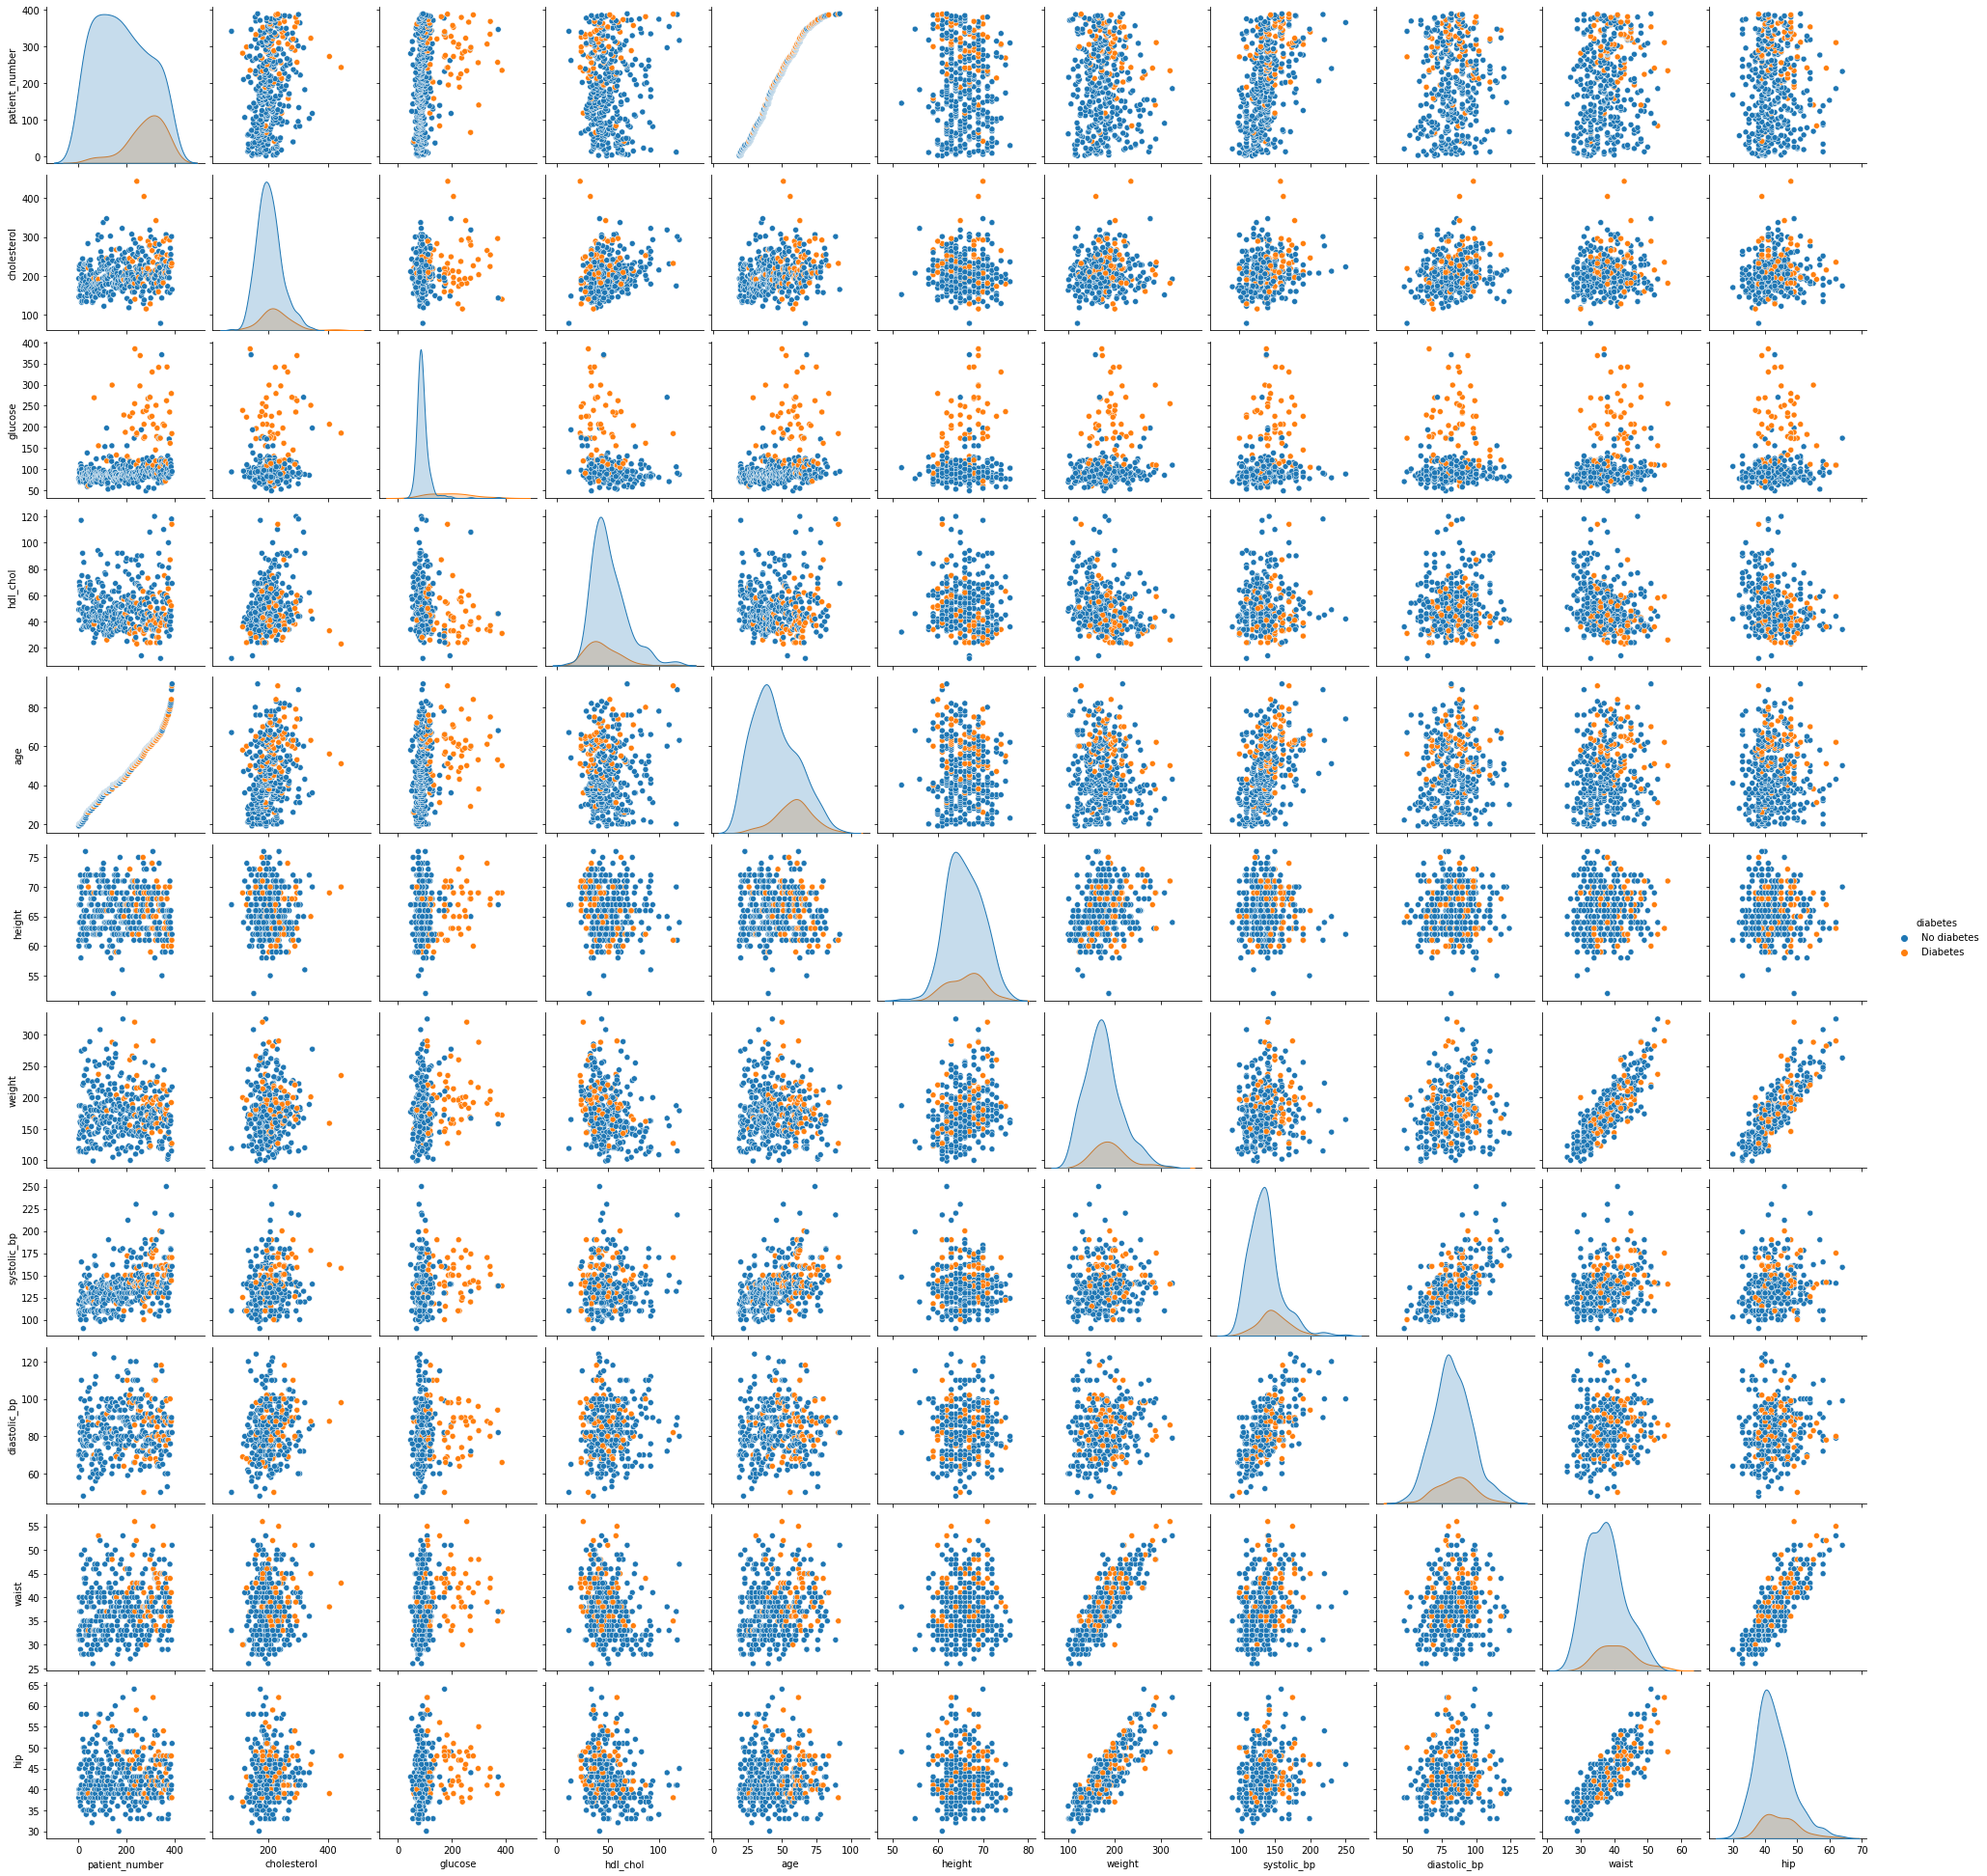

In [ ]:
sns.pairplot(data_raw, hue = 'diabetes')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc7607d510>,
      dtype=object)

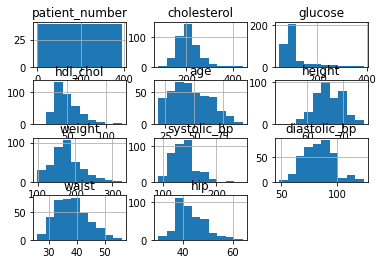

In [ ]:
# for col in data_raw.columns[1:-1]: #without patient number and diabetes indicator
#     plt.hist(data_raw[col])
#     plt.title(col)
#     plt.show()
data_raw.hist()

## Cleaning Data

In [ ]:
data = data_raw.copy()

There were issues with formating the numbers that were written as for example 6,58 instead of 6.58. Columns with this issue were formatted as strings, so we tackle this issue below.

In [ ]:
string_cols = list(data.columns[data.dtypes == 'object'])
#numbers with delimeters have issues (beacuse it's comma)

string_cols.remove('gender')
string_cols.remove('diabetes')

#Changing delimeter of "float" numbers to . and then casting it to float
data[string_cols] = data[string_cols].apply(lambda x: x.str.replace(',', '.').astype(float),
                        axis = 1)


# Making "diabetes" boolean
data.diabetes = data.diabetes == "Diabetes"

# making "gender" boolean
data.gender = (data.gender == "Female") #Male - 0, Female - 1 

# Removing patient number col
data = data.drop('patient_number', axis = 1)



In [ ]:
y = data.diabetes
X = data.drop('diabetes', axis = 1)
#continous predictors
binary_variables = ['gender']
X_c = X.drop(binary_variables, axis = 1)

In [ ]:
#all columns
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 2137,
                                                    stratify = y)

#only continous columns
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y, 
                                                    test_size=0.2,
                                                    random_state = 2137,
                                                    stratify = y)



In [ ]:
# Normalizing data

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler.fit(X_train_c)
X_train_c_s = scaler.transform(X_train_c)
X_test_c_s = scaler.transform(X_test_c)

In [ ]:
# check if its the same

sum(X_train.cholesterol == X_train_c.cholesterol) == X_train.shape[0]

True

In [ ]:
X_train_c.head()

cholesterol  glucose  hdl_chol  ...  waist  hip  waist_hip_ratio
200          191       83        88  ...     33   38             0.87
299          203       90        51  ...     36   41             0.88
255          242      297        34  ...     43   45             0.96
350          242       74        55  ...     41   47             0.87
123          156       86        34  ...     48   51             0.94

[5 rows x 13 columns]

## Balancing *data*

### Naive random over-sampling

It's just nonparametric bootstraping the samples that belong to underrepresented class 

In [ ]:
ros = RandomOverSampler(random_state = 21)

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

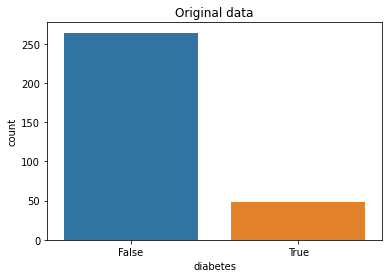

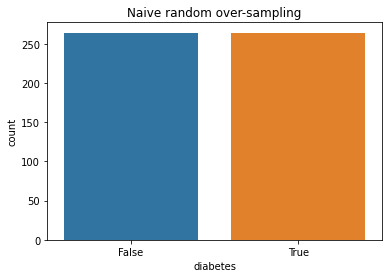

In [ ]:

sns.countplot(x = y_train)
plt.title('Original data')
plt.show()

sns.countplot(x = y_train_ros)
plt.title('Naive random over-sampling')
plt.show()


### Naive random over-sampling with shrinkage on continous data

It smooths the bootstrap procedure - makes new samples that don't overlap with each other.

In [ ]:
ros = RandomOverSampler(random_state = 37, shrinkage=0.05)

X_train_c_ros, y_train_c_ros = ros.fit_resample(X_train_c, y_train_c)

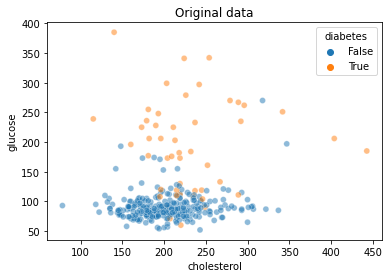

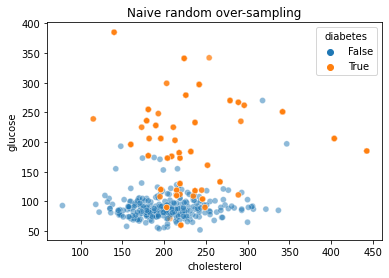

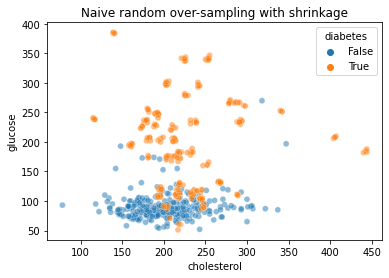

In [ ]:
sns.scatterplot(x = X_train['cholesterol'],y = X_train['glucose'], hue=y_train, alpha = 0.5)
plt.title('Original data')
plt.show()

sns.scatterplot(x = X_train_ros['cholesterol'],y = X_train_ros['glucose'], hue=y_train_ros, alpha = 0.5)
plt.title('Naive random over-sampling')
plt.show()


sns.scatterplot(x = X_train_c_ros['cholesterol'],y = X_train_c_ros['glucose'], hue=y_train_c_ros, alpha = 0.5)
plt.title('Naive random over-sampling with shrinkage')
plt.show()

### SMOTE - Synthetic Minority Oversampling Technique

Method to generate new samples:

for sample $x_i$ from original data set the new sample $x_{new}$ will be generated considering k nearest neghbors of $x_i$. One of the neighbor is selected, $x_{neighbor}$, and new sample is created as a random point on a straight line between $x_i$ and $x_{neighbor}$:

$$
x_{new} = x_i + \lambda \times (x_{neighbor} - x_i)
$$

where $\lambda$ is a random number from $[0, 1]$

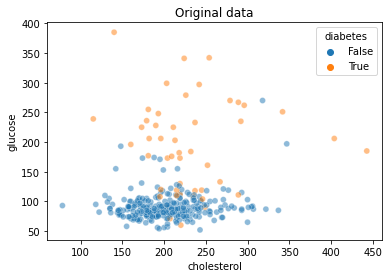

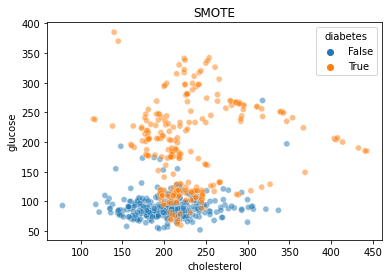

In [ ]:
X_train_smote, y_train_smote = SMOTE(random_state=21, k_neighbors=5).fit_resample(X_train, y_train)

sns.scatterplot(x = X_train['cholesterol'],y = X_train['glucose'], hue=y_train, alpha = 0.5)
plt.title('Original data')
plt.show()

sns.scatterplot(x = X_train_smote['cholesterol'],y = X_train_smote['glucose'], hue=y_train_smote, alpha = 0.5)
plt.title('SMOTE')
plt.show()

### ADASYN - Adaptive Synthetic

Works as SMOTE but the number of samples generated for each $x_i$ depends on how many samples are there in the neighborhood, that are from different class than $x_i$ (proportionaly).

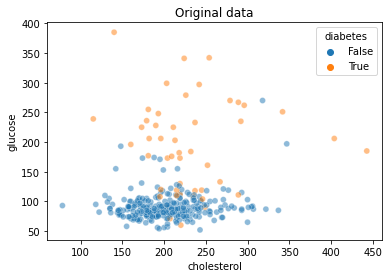

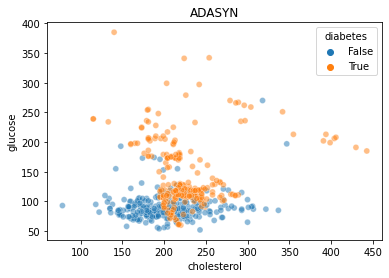

In [ ]:
X_train_adasyn, y_train_adasyn = ADASYN(random_state=37, n_neighbors= 5).fit_resample(X_train, y_train)

sns.scatterplot(x = X_train['cholesterol'],y = X_train['glucose'], hue=y_train, alpha = 0.5)
plt.title('Original data')
plt.show()

sns.scatterplot(x = X_train_adasyn['cholesterol'],y = X_train_adasyn['glucose'], hue=y_train_adasyn, alpha = 0.5)
plt.title('ADASYN')
plt.show()

### SMOTEENN - edited nearest-neighbors

This method combines oversampling and undersampling.

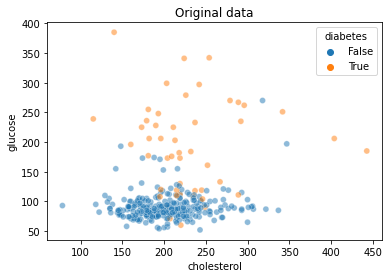

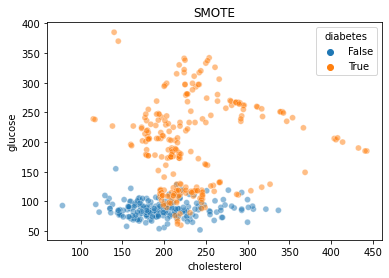

In [ ]:
X_train_smoteenn, y_train_smoteenn = SMOTEENN(random_state=21).fit_resample(X_train, y_train)

sns.scatterplot(x = X_train['cholesterol'],y = X_train['glucose'], hue=y_train, alpha = 0.5)
plt.title('Original data')
plt.show()

sns.scatterplot(x = X_train_smoteenn['cholesterol'],y = X_train_smoteenn['glucose'], hue=y_train_smoteenn, alpha = 0.5)
plt.title('SMOTENN')
plt.show()

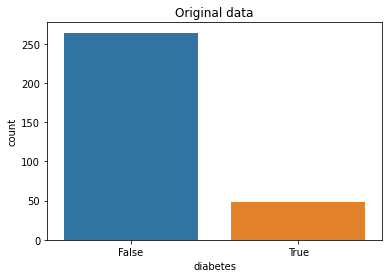

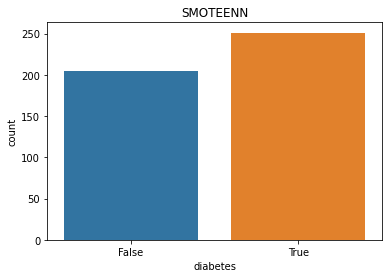

In [ ]:
sns.countplot(x = y_train)
plt.title('Original data')
plt.show()

sns.countplot(x = y_train_smoteenn)
plt.title('SMOTEENN')
plt.show()

## Classification 

We will use the following procedures:
* K nearest Neighbours​
* Logistic regression​
* Naïve Bayes​
* Decision trees​
* Random forest​
* Explainable Boosting Machine​
* Ada-Boost​
* SVC​
* XG Boost

For each of the classifiers we write a wrapper function inside which we choose the hyperparameters to pass to the classifiera and the classifier is trained


Here we have a function whiich scores the classifier saving its train and test F1 scores as well as sensitivity and specificity.

In [ ]:
def score_classifier (classifier,X_train, X_test, y_train, y_test):
    class_y_train = classifier.predict(X_train)
    class_y_test = classifier.predict(X_test)
    class_train_score = metrics.f1_score(y_train, class_y_train) 
    class_test_score = metrics.f1_score(y_test,class_y_test)
    class_conf_mat = metrics.confusion_matrix(y_test, class_y_test)
    class_sens, class_spec = class_conf_mat[1,1] / (class_conf_mat[1,1] + class_conf_mat[1,0]) , class_conf_mat[0,0] / (class_conf_mat[0,0] + class_conf_mat[0,1])
    return({"train_f1" : class_train_score, "test_f1" : class_test_score, "sensitivity":class_sens, "specificity":class_spec})


### K Nearest Neighbors


In [ ]:
def perform_knn(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()
    knn_parameters = {"n_neighbors" : range(1, 20, 2)}

    knn_gs = GridSearchCV(knn, knn_parameters, scoring = "f1", cv = 7)
    knn_gs.fit(X_train, y_train)

    res_knn = score_classifier(knn_gs,X_train, X_test , y_train, y_test)
    return res_knn

### Logistic Regression


In [ ]:
def perform_logreg(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg.fit(X_train_scaled,y_train)
    res_logreg = score_classifier(logreg,X_train_scaled, X_test_scaled , y_train, y_test)
    return res_logreg

### Naive Bayes

#### Gaussian Naive Bayes 
Gaussian Naive Bayes



In [ ]:
def perform_gnb(X_train, y_train, X_test, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    res_gnb = score_classifier(gnb,X_train, X_test , y_train, y_test)
    return res_gnb

#### Complement Naive Bayes 
 good for imbalanced data set

In [ ]:
def perform_cnb(X_train, y_train, X_test, y_test):
    cnb = ComplementNB()
    cnb.fit(X_train, y_train)
    res_cnb = score_classifier(cnb,X_train, X_test , y_train, y_test)
    return res_cnb

Complement Gaussian Naive Bayes F1 train score:  0.6947368421052632
Complement Gaussian Naive Bayes F1 test score:  0.6956521739130435


### Decission trees

In [ ]:
dec_tree = DecisionTreeClassifier(criterion="entropy") 
dec_tree.fit(X_train, y_train) # maximal tree grown on full training dataset
y_dec_tree = dec_tree.predict(X_train)
unpruned_train_score = metrics.f1_score(y_train, y_dec_tree) # unpruned decision tree is overfittes
unpruned_test_score = metrics.f1_score(y_test, dec_tree.predict(X_test))
print(f"Unpruned train F score {unpruned_train_score:.2}, unpruned test F score {unpruned_test_score:.2}")



Unpruned train F score 1.0, unpruned test F score 0.67


The unpruned tree overfits so we use cost complexity pruning

#### Cost complexity pruning

We use minimal cost complexicity pruning algorithm. It is parametrized by complexicity hyperparameter $\alpha > 0$. We use it to define the cost complexity measure $R_{\alpha}(T)$ for tree $T$.
$$R_\alpha(T) = R(T) + \alpha |\tilde{T}|$$
where $|\tilde{T}|$ denotes the number of terminal nodes of tree $T$, and $R(T)$ is total misclassification rate of the terminal nodes. We find a subtree of $T$ which minimizes $R_\alpha(T)$.

We find the best parameter $\alpha$ by 10-fold cross validation. The first observation is that we only have finite number of $\alpha$'s to check as we only need to check the $\alpha$ which results in change of the measure.

Lets denote by $L_k$ and $L^{(m)}$ the k-th training and testing samples from cross-validation. We grow 11 maximal trees - one for each fold of cross-validation and one for the whole dataset. For each of such maximal trees we denote $T^{(m)}(\alpha)$ the corresponding minimal cost complexicity pruned subtree for complexity parameter $\alpha$. For the original  maximum tree we get an increasing sequence of parameters $\alpha_1, \dots, \alpha_s$ which are the critical values of $\alpha$, where the measure $R_\alpha$ value changes. We compute the cross-validated $F_1$ measure of the minimal cost complexicity pruned trees in points $\tilde\alpha_k = \sqrt{\alpha_k\alpha_{k+1}}$ and choose the parameter $\tilde\alpha_k$ which maximizes it.




In [ ]:
def perform_decisiontrees(X_train, y_train, X_test, y_test):
    dec_tree = DecisionTreeClassifier(criterion="entropy") 
    dec_tree.fit(X_train, y_train)
    path = dec_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities # critical values alphas for the original maximum tree
    ccp_alphas = np.array(ccp_alphas) 
    pos_alphas = np.sqrt(ccp_alphas[:-1] * ccp_alphas[1:]) # possible alphas to choose from
    f_scores = np.zeros(shape=pos_alphas.shape) # list for CV F scoress correspondnig to possible alphas

    # stratified folding
    skf = StratifiedKFold(n_splits=10, random_state=2022, shuffle=True)
    for k_train, k_test in skf.split(X_train, y_train):
        k_max_tree = DecisionTreeClassifier(criterion="entropy", random_state=2022) 
        k_max_tree.fit(X_train.iloc[k_train], y_train.iloc[k_train]) # maximal tree grown on k-th CV-fold
        k_path = dec_tree.cost_complexity_pruning_path(X_train.iloc[k_train], y_train.iloc[k_train])
        k_ccp_alphas = path.ccp_alphas # get critical alpha values for tree grown on k-th CV-fold
        k_pos_alphas_idx = np.searchsorted(k_ccp_alphas, pos_alphas, side='right')
        k_pos_alphas_idx -= (k_pos_alphas_idx > 1)
        corresp_alphas = k_ccp_alphas[k_pos_alphas_idx]        

        for i in range(len(corresp_alphas)):
            alpha = corresp_alphas[i]
            if i > 0:
                last_alpha = corresp_alphas[i-1]
                if last_alpha == alpha:
                    f_scores[i] += alpha_test_score
                    continue
            alpha_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
            alpha_tree.fit(X_train.iloc[k_train], y_train.iloc[k_train])
            y_alpha = alpha_tree.predict(X_train.iloc[k_test])
            alpha_test_score = metrics.f1_score(y_train.iloc[k_test], y_alpha)
            f_scores[i] += alpha_test_score

    f_scores /= 10
    best_alpha = pos_alphas[np.argmax(f_scores)] # selected best alpha for pruning

    pruned_dec_tree = DecisionTreeClassifier(criterion="entropy", ccp_alpha=best_alpha, random_state=2137) 
    pruned_dec_tree.fit(X_train, y_train) # pruned tree grown on full training dataset
    res_pruned_dec_tree = score_classifier(pruned_dec_tree,X_train, X_test , y_train, y_test)

    return res_pruned_dec_tree



### Random Forest

In [ ]:
def perform_randomforest(X_train, y_train, X_test, y_test):
    m = len(X_train.columns)
    random_forest = RandomForestClassifier(random_state=2022)
    rand_forest_parameters = {"n_estimators" : range(100, 300, 50), "max_features" : tuple(range(1,m+1))}
    rand_forest_gs = GridSearchCV(random_forest, rand_forest_parameters, scoring = "f1", cv = 7)
    rand_forest_gs.fit(X_train, y_train)
    res_rand_forest_gs = score_classifier(rand_forest_gs,X_train, X_test , y_train, y_test)
    fit_imp = pd.DataFrame({'Feature_names':X_train.columns,\
                            'Feature_importances':rand_forest_gs.best_estimator_.feature_importances_})
    fit_imp['Method'] = "R Forest"
    return res_rand_forest_gs, fit_imp


We use grid search to find the best value of number of trees and the maximal number of features considered at each split.

### Explainable boosting machine

Apart form the techniques discussed on the lectures we will be also using Explainable boosting machine. 

EBM is a generalized additive model (GAM) of the form:
$$g(E[y])=β_0+∑f_j(x_j)$$

where $g$ is the link function - different for regression and classification.

EBM learns each function $f_j$ utilizing modern machine learning techniques - bagging and boosting. We restrict the boosting procedure to train one variale at the time, round-robin fashion. We use slow learning rate so that the order of the features in the data frame is not imporatant.

EBM is a glassbox model. Below we present the interactive summary of the contribution of each of the variables.

In [ ]:
ebm = ExplainableBoostingClassifier(random_state=2137)
ebm.fit(X_train, y_train)


ExplainableBoostingClassifier(feature_names=['cholesterol', 'glucose',
                                             'hdl_chol', 'chol_hdl_ratio',
                                             'age', 'gender', 'height',
                                             'weight', 'bmi', 'systolic_bp',
                                             'diastolic_bp', 'waist', 'hip',
                                             'waist_hip_ratio',
                                             'glucose x systolic_bp',
                                             'glucose x waist',
                                             'glucose x chol_hdl_ratio',
                                             'glucose x hdl_chol',
                                             'cholesterol x glucose',
                                             'glucose x bmi', 'glucose x age',
                                             'glucose x waist_hip_ra...
                              feature_types=['continuous', 'continuou

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

In [ ]:
def perform_ebm(X_train, y_train, X_test, y_test):
    ebm = ExplainableBoostingClassifier(random_state=2137)
    ebm.fit(X_train, y_train)
    res_ebm = score_classifier(ebm,X_train, X_test , y_train, y_test)
    fit_imp = pd.DataFrame({'Feature_names':ebm.feature_names, 'Feature_importances':ebm.feature_importances_})
    fit_imp['Method'] = 'EBM'
    return res_ebm, fit_imp



### Ada-Boost

In [ ]:
def perform_adaboost(X_train, y_train, X_test, y_test):
    ada_boost  =  AdaBoostClassifier(n_estimators = 50, random_state=2022)
    ada_boost.fit(X_train, y_train)
    res_ada_boost = score_classifier(ada_boost,X_train, X_test , y_train, y_test)
    return res_ada_boost

### SVC

We use the SVC with linear kernel as well as SVC with kernel chosen from 'polynomial' and 'radial basis functions' based on grid search of the type of kernel, penalty on misclasification VS the surface smoothnes and the degree of the polynomials in the case of polynomial kernel.

In [ ]:
def perform_svc_linear(X_train, y_train, X_test, y_test):
    # Svc linear
    svc_lin = LinearSVC(dual = False, max_iter = 3800)
    svc_lin_parameters = [{"C" : np.arange(0.5, 5.0, 0.1), "penalty" : ["l2"]},{"C" : np.arange(0.002, 0.015, 0.001), "penalty" : ["l1"]}]
    svc_lin_gs = GridSearchCV(svc_lin, svc_lin_parameters, scoring = "f1", cv = 7)
    svc_lin_gs.fit(X_train, y_train)

    res_svc_lin_gs = score_classifier(svc_lin_gs,X_train, X_test , y_train, y_test)
    return res_svc_lin_gs


In [ ]:
def perform_svc(X_train, y_train, X_test, y_test):
    svc =  SVC()
    svc_parameters = [{"C" : np.arange(0.5, 4.0, 0.1), "kernel" : ["poly"], "degree" : range(1, 5, 1)}, {"C" : np.arange(0.5, 4.0, 0.1), "kernel" : ["rbf"]}]

    svc_gs = GridSearchCV(svc, svc_parameters, scoring = "f1", cv = 7)
    svc_gs.fit(X_train, y_train)

    res_svc_gs = score_classifier(svc_gs,X_train, X_test, y_train, y_test)
    return res_svc_gs

### XG-Boost

Parameter space is too large so instead of doing grid search we use bayesian optimization to find the best parametres.

In [ ]:
def perform_xgboost(X_train, y_train, X_test, y_test):

    bayes_cv_xgboost = BayesSearchCV(
        estimator = XGBClassifier(
            n_jobs = 1,
            objective = 'binary:logistic',
            eval_metric = 'auc',
            silent=1,
            validate_parameters = False,
            tree_method='approx'
        ),
        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_split_loss': (1e-9, 0.5, 'log-uniform'),
            'min_child_weight': (0, 10),
            'max_depth': (1, 5),
            'max_delta_step': (0, 20),
            'colsample_bytree': (0.01, 0.8, 'uniform'),
            'colsample_bylevel': (0.01, 0.8, 'uniform'),
            'lambda': (1e-9, 1000.0, 'log-uniform'),
            'alpha': (1e-9, 1.0, 'log-uniform'),
            'n_estimators': (50, 140)
                },    
        scoring = 'f1',
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=2022
        ),
        n_jobs = 20,
        n_iter = 50,   
        verbose = 0,
        refit = True,
        random_state = 2022
    )
    
    bayes_cv_xgboost.fit(X_train, y_train)
    res_xgboost = score_classifier(bayes_cv_xgboost, X_train, X_test , y_train, y_test)

    fit_imp = pd.DataFrame({'Feature_names':X_train.columns,\
                            'Feature_importances':bayes_cv_xgboost.best_estimator_.feature_importances_})
    fit_imp['Method'] = "XG Boost"

    return res_xgboost, fit_imp

### Function

Main function to train all the classificators and test them on given data

In [ ]:

def perform_classifications(X_train, y_train, X_test, y_test):

    results_dic = {}
    feature_imp_dic = {}

    ## KNN
    print("Starting!")
    results_dic['knn'] = perform_knn(X_train, y_train, X_test, y_test)
    print("KNN done!")

    ##Logistic regression
    results_dic["logreg"] = perform_logreg(X_train, y_train, X_test, y_test)
    print("Logreg done!")

    ##Complement Naive Bayes
    results_dic["cnb"] = perform_cnb(X_train, y_train, X_test, y_test)
    print("CNB done!")

    ## Gaussian Naive Bayes
    results_dic["gnb"] = perform_gnb(X_train, y_train, X_test, y_test)
    print("GNB done!")

    ## decision trees
    results_dic["pruned_dec_tree"] = perform_decisiontrees(X_train, y_train, X_test, y_test)
    print("Decision trees done!")

    ## random forest
    results_dic["rand_forest_gs"], feature_imp_dic["rand_forest_gs"] = perform_randomforest(X_train, y_train, X_test, y_test)
    print("Random forest done!")

    ## ebm
    results_dic["EBM"], feature_imp_dic["EBM"] = perform_ebm(X_train, y_train, X_test, y_test)
    print("EBM done!")

    ## ada-boost
    results_dic["ada_boost"] = perform_adaboost(X_train, y_train, X_test, y_test)
    print("Ada-boost done!")

    ## svc linear
    results_dic["svc_lin"] = perform_svc_linear(X_train, y_train, X_test, y_test)
    print("SVC linear done!")

    ## svc
    results_dic["svc"] = perform_svc(X_train, y_train, X_test, y_test)
    print("SVC done!")

    ## xgboost
    results_dic["xg_boost"], feature_imp_dic["xg_boost"] = perform_xgboost(X_train, y_train, X_test, y_test)
    print("XGBoost done!")

    ## Making data frame from disctionary
    results_pd = pd.DataFrame.from_dict(results_dic, orient = 'index')
    results_pd.reset_index(level=0, inplace=True)
    cl_names_dict = {"index" : "Method", "train_f1" :'Train F1 score',	"test_f1" :'Test F1 score', "sensitivity" : "Sensitivity",	"specificity" : "Specificity" }
    results_pd.rename(columns = {"index" : "Method", "train_f1" :'Train F1 score',	"test_f1" :'Test F1 score', "sensitivity" : "Sensitivity",	"specificity" : "Specificity" }, inplace = True)
    
    feature_imp = pd.concat(feature_imp_dic).reset_index(drop=True)
    feature_imp['Feature_importances'] = feature_imp.groupby(['Method']).Feature_importances.transform(lambda x: x/x.sum())
    
    return results_pd,feature_imp

## Results

Below we present the results of the classifiers on the original imbalanced data and then on the data balanced by each of the used data balancing techniques. We also present the variable importance as specified by random forest, XGboost and EBM.

We first present the results on the plots and follow with the summary of all the results in the tables at the end.

### Original data

In [ ]:
results_whole, feature_imp_whole = perform_classifications(X_train, y_train, X_test, y_test)
results_whole['Data'] = 'Original'
feature_imp_whole['Data'] = 'Original'

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


(0.0, 1.01)

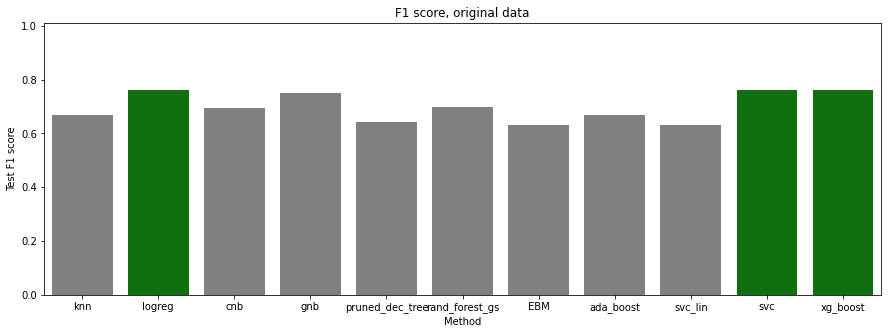

In [ ]:
clrs = ["green" if (x >= max(results_whole['Test F1 score'])) else "grey" for x in results_whole['Test F1 score']]
plt.rcParams['figure.figsize'] = [10, 7]
#plt.bar(results_pd['Method'], results_pd['Result'], color = clrs)
plt.rcParams['figure.figsize'] = [15, 5]
sns.barplot(x = results_whole['Method'], 
            y = results_whole['Test F1 score'], 
            palette = clrs)
plt.title('F1 score, original data')
plt.ylim(0, 1.01)

(0.0, 1.01)

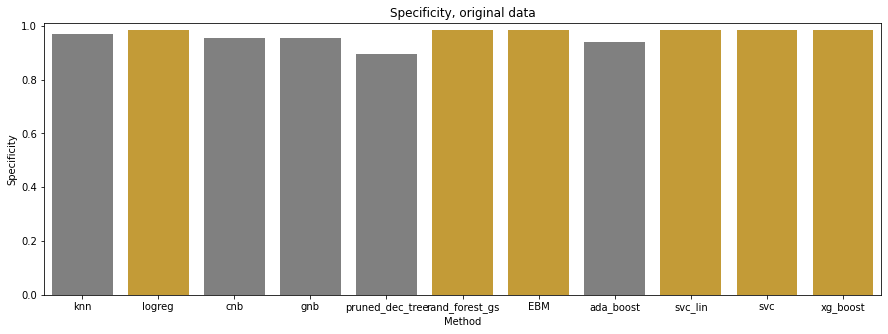

In [ ]:
clrs = ["goldenrod" if (x >= max(results_whole['Specificity'])) else "grey" for x in results_whole['Specificity']]
plt.rcParams['figure.figsize'] = [10, 7]
#plt.bar(results_pd['Method'], results_pd['Result'], color = clrs)
plt.rcParams['figure.figsize'] = [15, 5]
sns.barplot(x = results_whole['Method'], 
            y = results_whole['Specificity'], 
            palette = clrs)
plt.title('Specificity, original data')
plt.ylim(0, 1.01)

(0.0, 1.01)

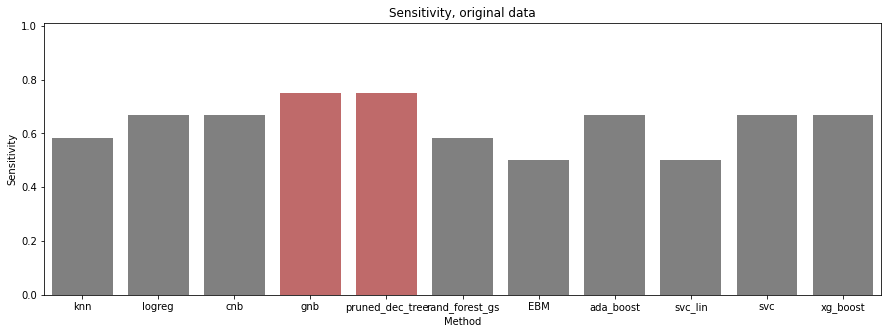

In [ ]:
clrs = ["indianred" if (x >= max(results_whole['Sensitivity'])) else "grey" for x in results_whole['Sensitivity']]
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.figsize'] = [15, 5]
sns.barplot(x = results_whole['Method'], 
            y = results_whole['Sensitivity'], 
            palette = clrs)
plt.title('Sensitivity, original data')
plt.ylim(0, 1.01)

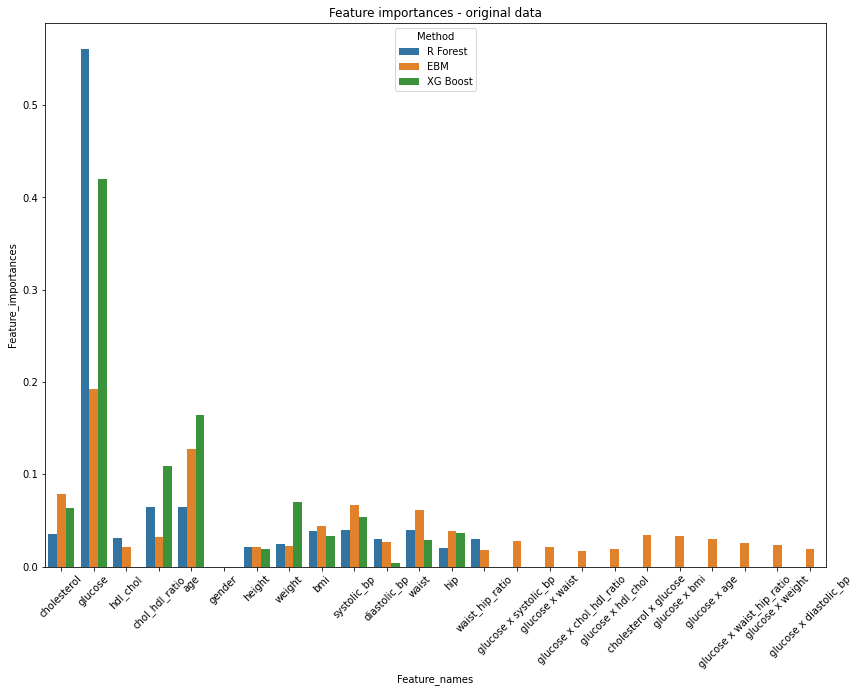

In [ ]:
plt.rcParams['figure.figsize'] = [14, 10]
sns.barplot(x = feature_imp_whole['Feature_names'],
            y = feature_imp_whole['Feature_importances'],
            hue = feature_imp_whole['Method'])
plt.title('Feature importances - original data')
plt.xticks(rotation=45)
plt.show()

### Using various data balancing techniques

**Naive random oversampling**

In [ ]:
results, feauture_imp = perform_classifications(X_train_ros, y_train_ros, X_test, y_test)
results['Data'] = 'ROS'
feauture_imp['Data'] = 'ROS'
results_whole = results_whole.append(results)
feature_imp_whole = feature_imp_whole.append(feauture_imp)

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


**Naive random oversampling with shrinkage**

In [ ]:
results, feauture_imp = perform_classifications(X_train_c_ros, y_train_c_ros, X_test_c, y_test)
results['Data'] = 'ROSc'
feauture_imp['Data'] = 'ROSc'
results_whole = results_whole.append(results)
feature_imp_whole = feature_imp_whole.append(feauture_imp)

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


**SMOTE**

In [ ]:
results, feauture_imp = perform_classifications(X_train_smote, y_train_smote, X_test, y_test)
results['Data'] = 'SMOTE'
feauture_imp['Data'] = 'SMOTE'
results_whole = results_whole.append(results)
feature_imp_whole = feature_imp_whole.append(feauture_imp)

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


**SMOTEENN**

In [ ]:
results, feauture_imp = perform_classifications(X_train_smoteenn, y_train_smoteenn, X_test, y_test)
results['Data'] = 'SMOTEENN'
feauture_imp['Data'] = 'SMOTEENN'
results_whole = results_whole.append(results)
feature_imp_whole = feature_imp_whole.append(feauture_imp)

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


**ADASYN**

In [ ]:
results, feauture_imp = perform_classifications(X_train_adasyn, y_train_adasyn, X_test, y_test)
results['Data'] = 'ADASYN'
feauture_imp['Data'] = 'ADASYN'
results_whole = results_whole.append(results)
feature_imp_whole = feature_imp_whole.append(feauture_imp)

Starting!
KNN done!
Logreg done!
CNB done!
GNB done!
Decision trees done!
Random forest done!
EBM done!
Ada-boost done!
SVC linear done!
SVC done!
XGBoost done!


The variable importance for each of the data balancing teqniques.

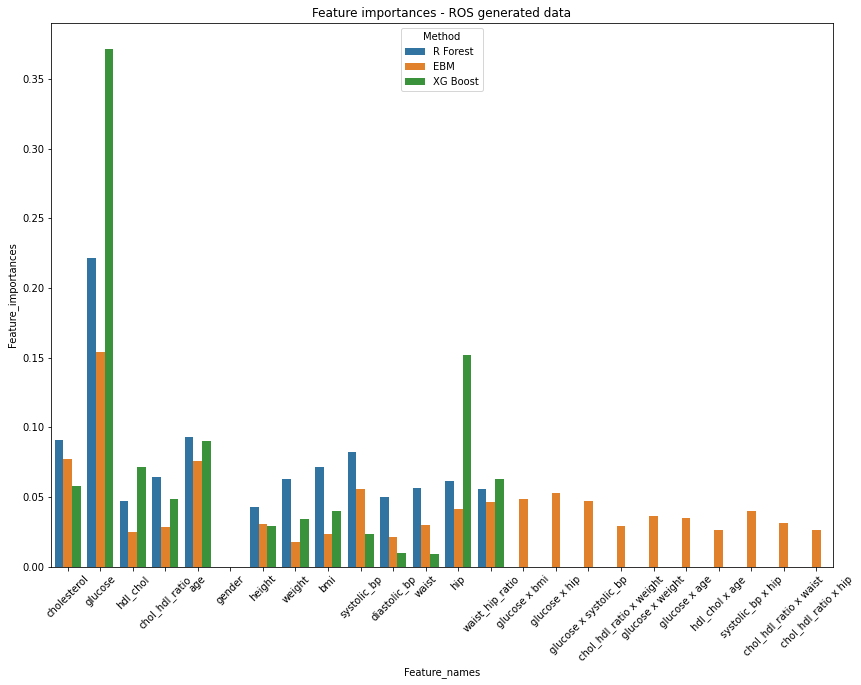

In [ ]:
plt.rcParams['figure.figsize'] = [14, 10]
sns.barplot(x = feauture_imp['Feature_names'],
            y = feauture_imp['Feature_importances'],
            hue = feauture_imp['Method'])
plt.title('Feature importances - ROS generated data')
plt.xticks(rotation=45)
plt.show()


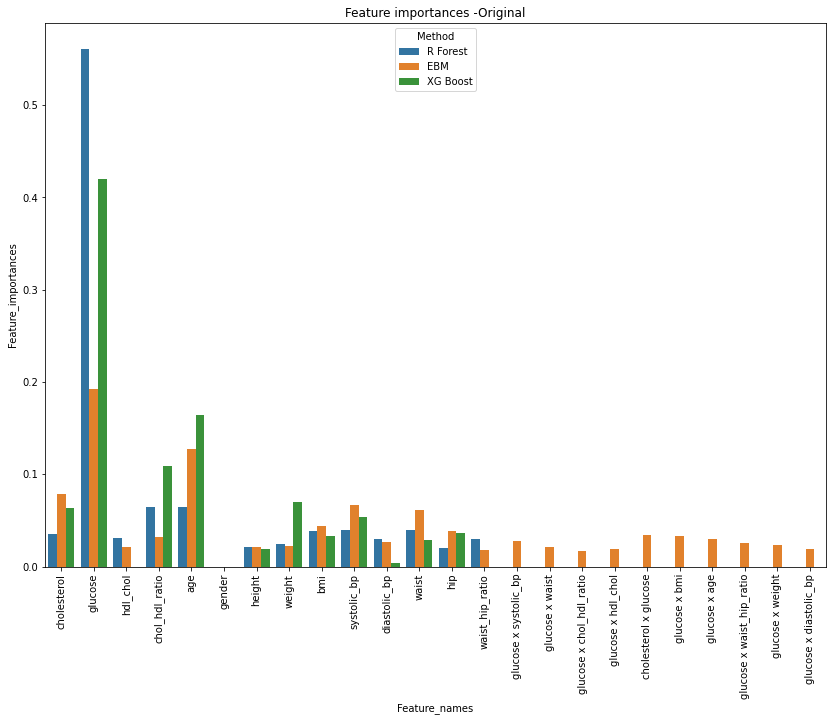

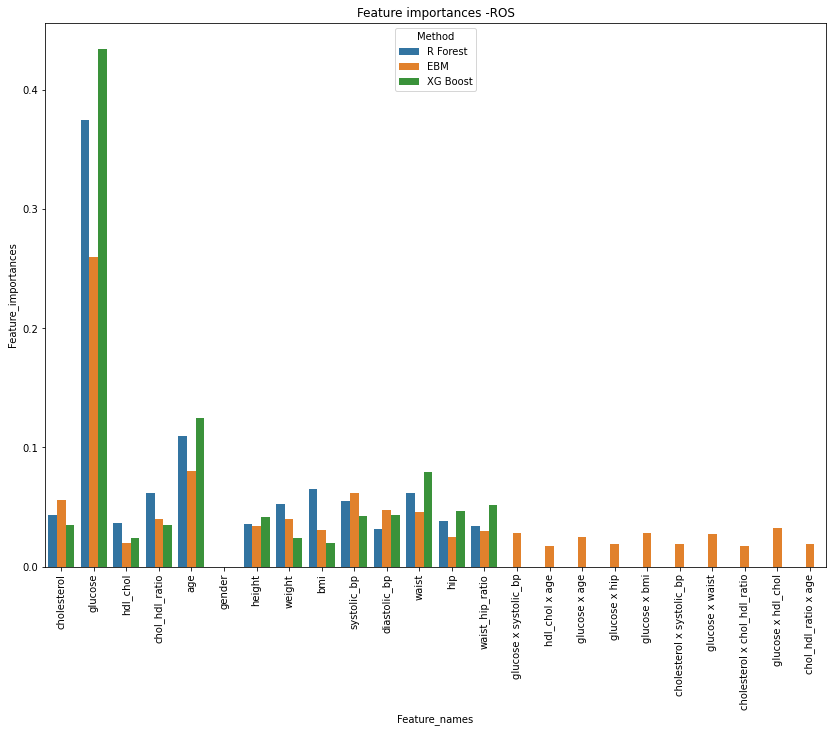

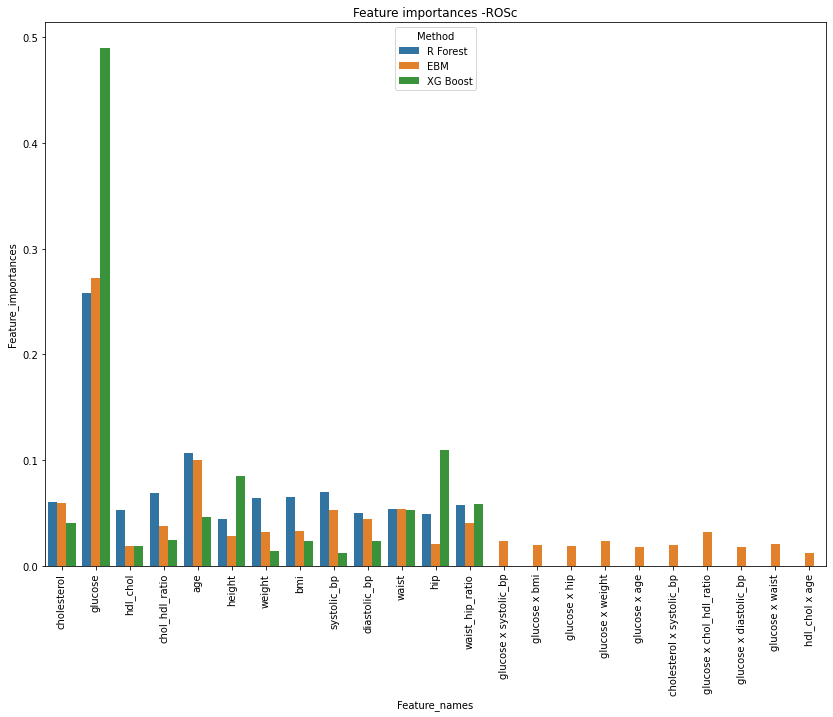

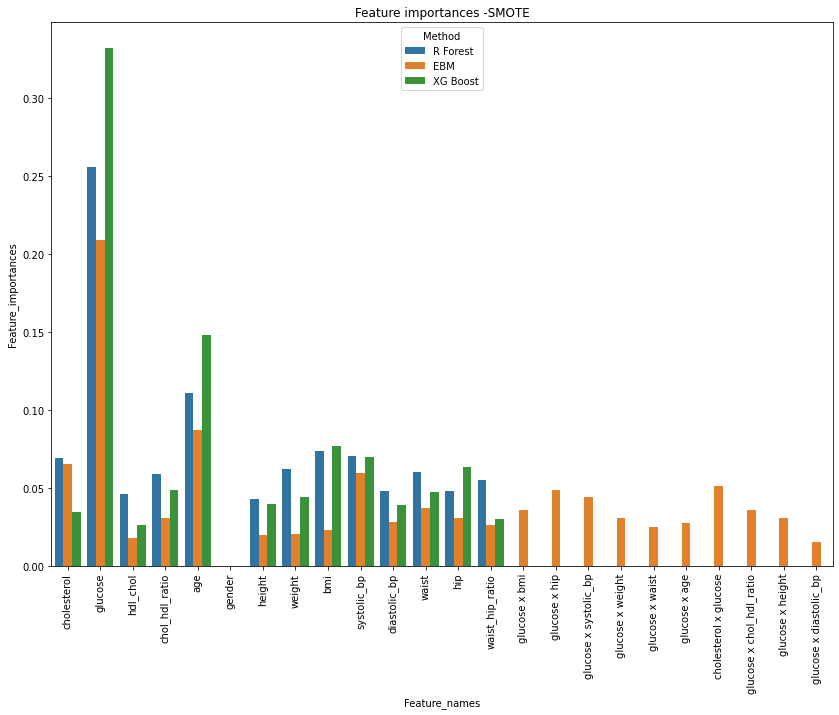

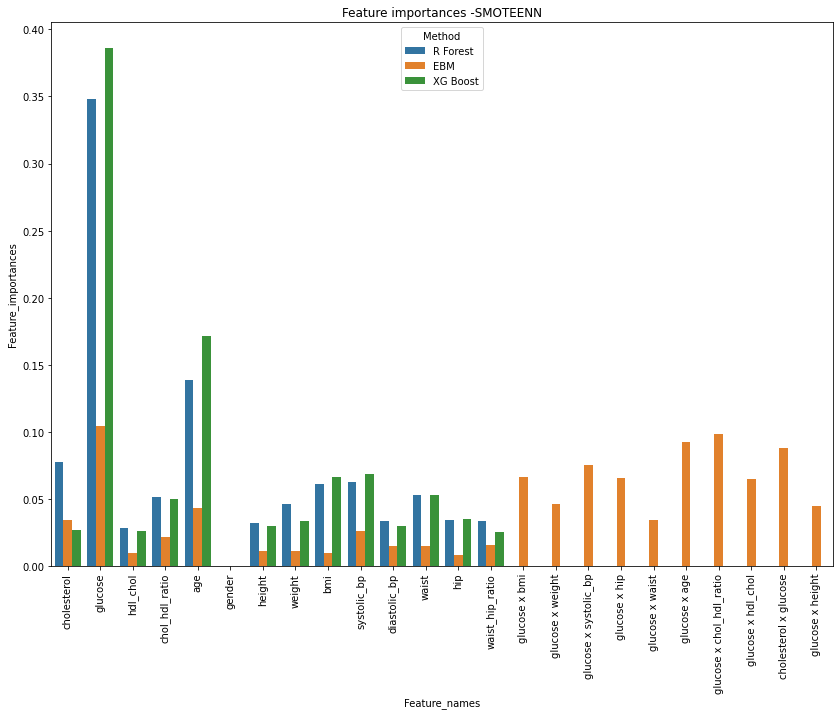

In [ ]:
for data_method in ['Original', 'ROS', 'ROSc', 'SMOTE', 'SMOTEENN']:
    plt.rcParams['figure.figsize'] = [14, 10]
    sns.barplot(data =feature_imp_whole.loc[feature_imp_whole['Data']==data_method],\
                x ='Feature_names',
                y = 'Feature_importances',
                hue = 'Method')
    title_str = 'Feature importances -'+ data_method
    plt.title(title_str)
    plt.xticks(rotation=90)
    plt.show()

Here we present some of the most important features. We can see that although the precise values of the 'importance' changed, the overall judgemnt of which variables were the most important did not.

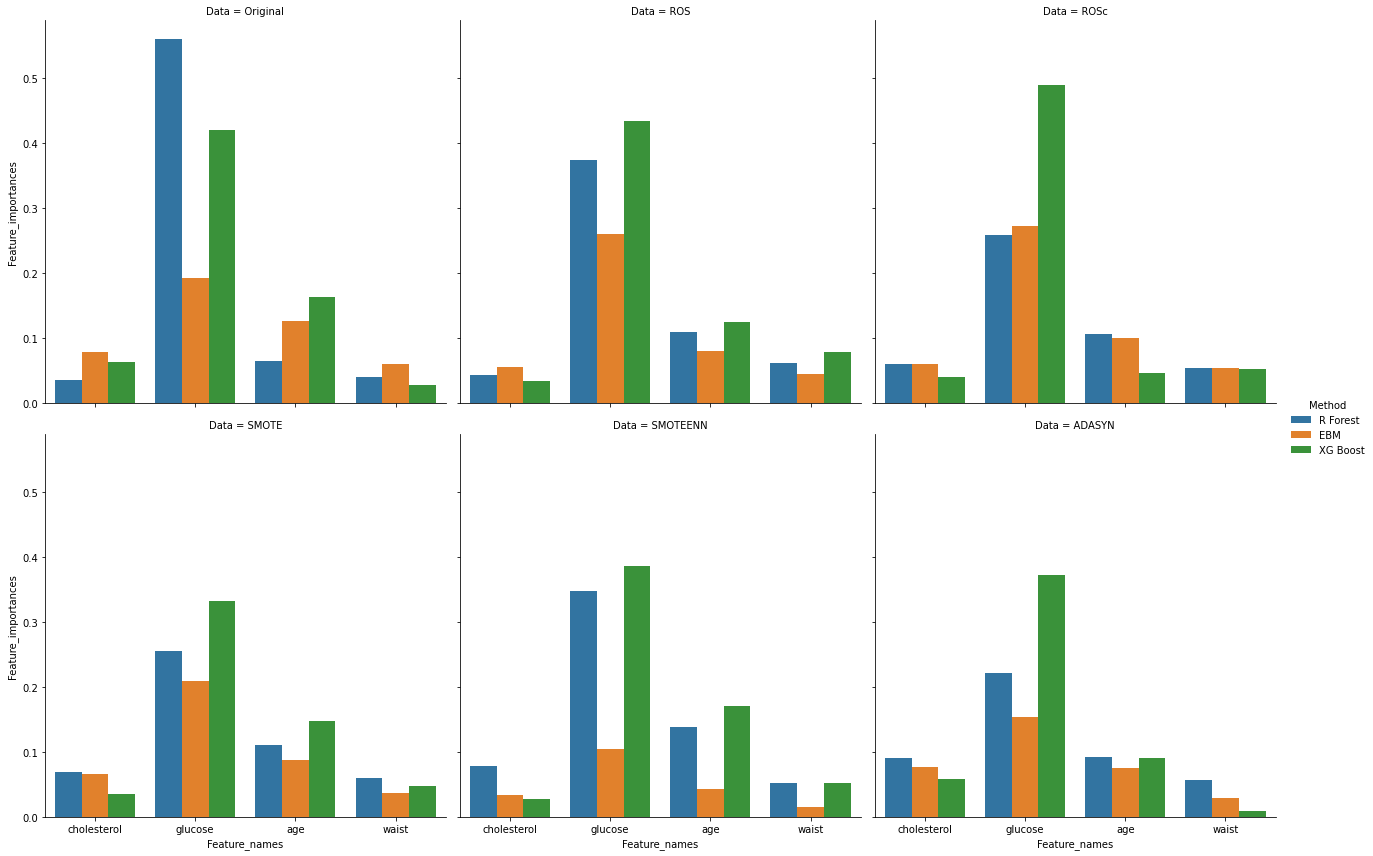

In [ ]:
plt.rcParams['figure.figsize'] = [14, 10]
sns.catplot(data = feature_imp_whole.loc[feature_imp_whole['Feature_names'].isin(['cholesterol', 'glucose', 'age','waist'])],\
            x = 'Feature_names',\
            y = 'Feature_importances',\
            hue = 'Method',\
            col = 'Data',\
            kind = 'bar',\
            col_wrap = 3, 
            height = 6)

plt.show()

We proceed to present the F1 scores, sensitivity and specificity of all the classifiers on each of the data sets - the original and the 'balanced' ones.

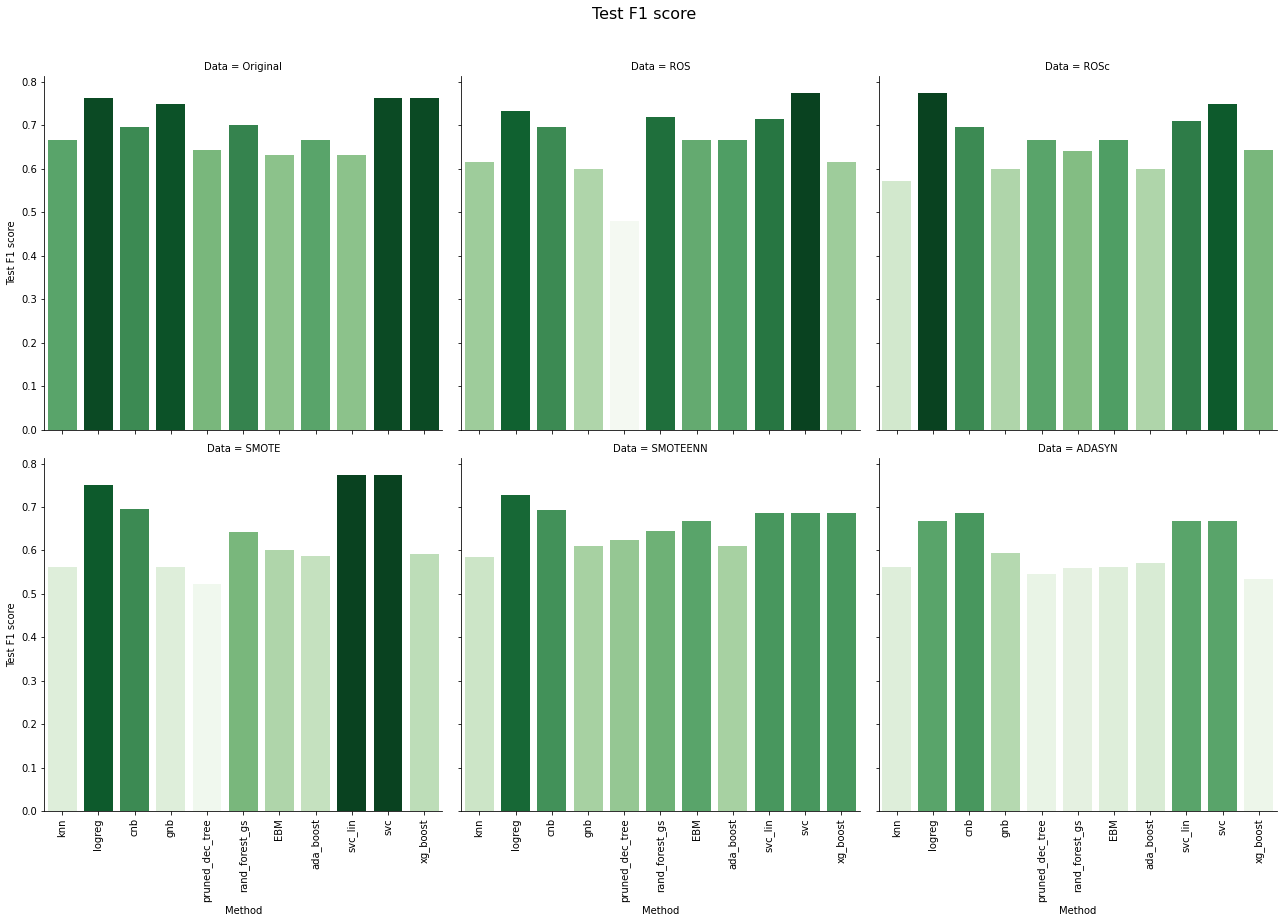

In [ ]:
g = sns.catplot(data = results_whole,
            x = 'Method',
            y = 'Test F1 score',
            col = 'Data',
            kind = 'bar',
            hue = 'Test F1 score',
            legend = False,
            palette = 'Greens',
            dodge = False,
            height = 6,
            col_wrap = 3)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Test F1 score', fontsize=16)
g.set_xticklabels(rotation=90)

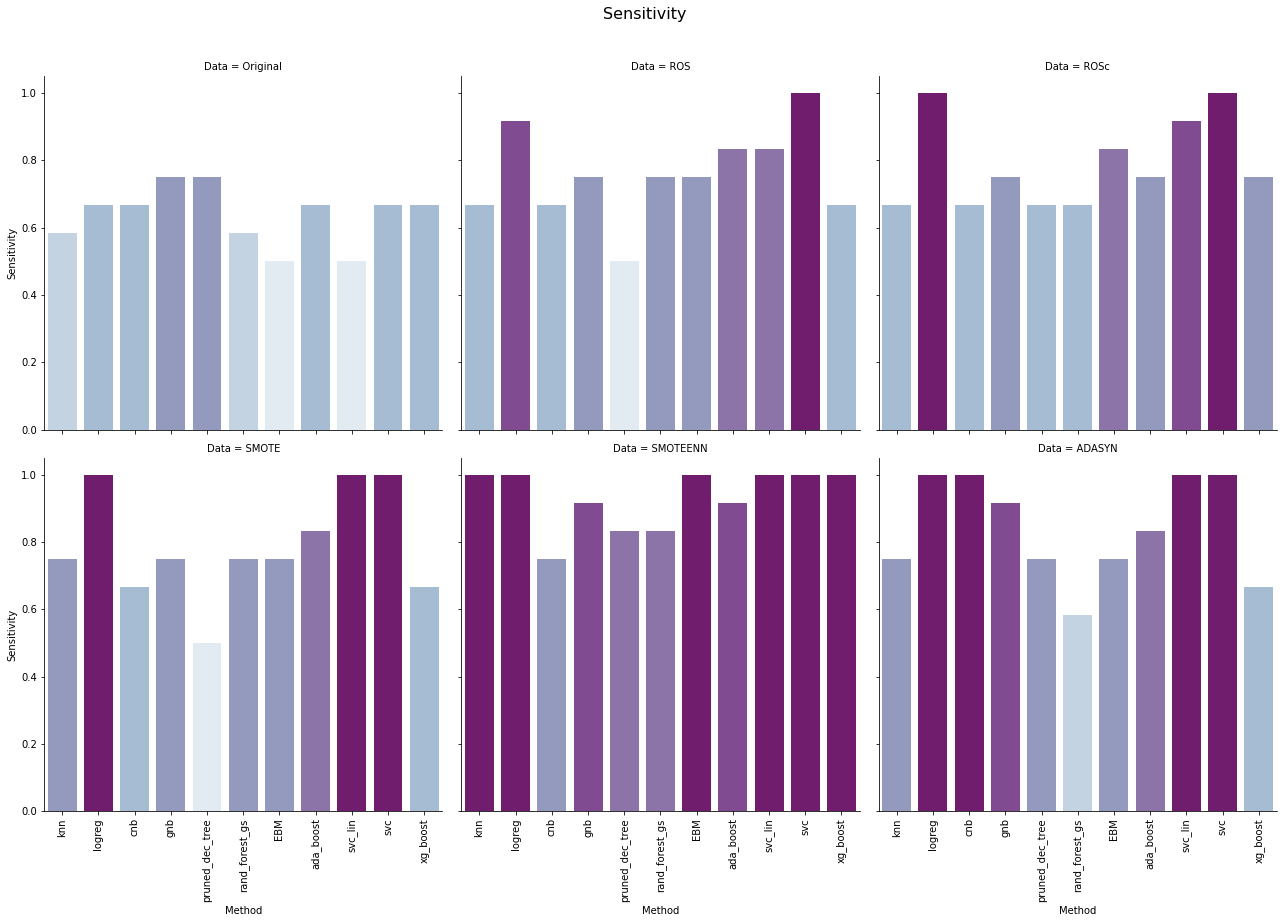

In [ ]:
g = sns.catplot(data = results_whole,
            x = 'Method',
            y = 'Sensitivity',
            col = 'Data',
            kind = 'bar',
            hue = 'Sensitivity',
            legend = False,
            palette = 'BuPu',
            dodge = False,
            height = 6,
            col_wrap = 3)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sensitivity', fontsize=16)
g.set_xticklabels(rotation=90)

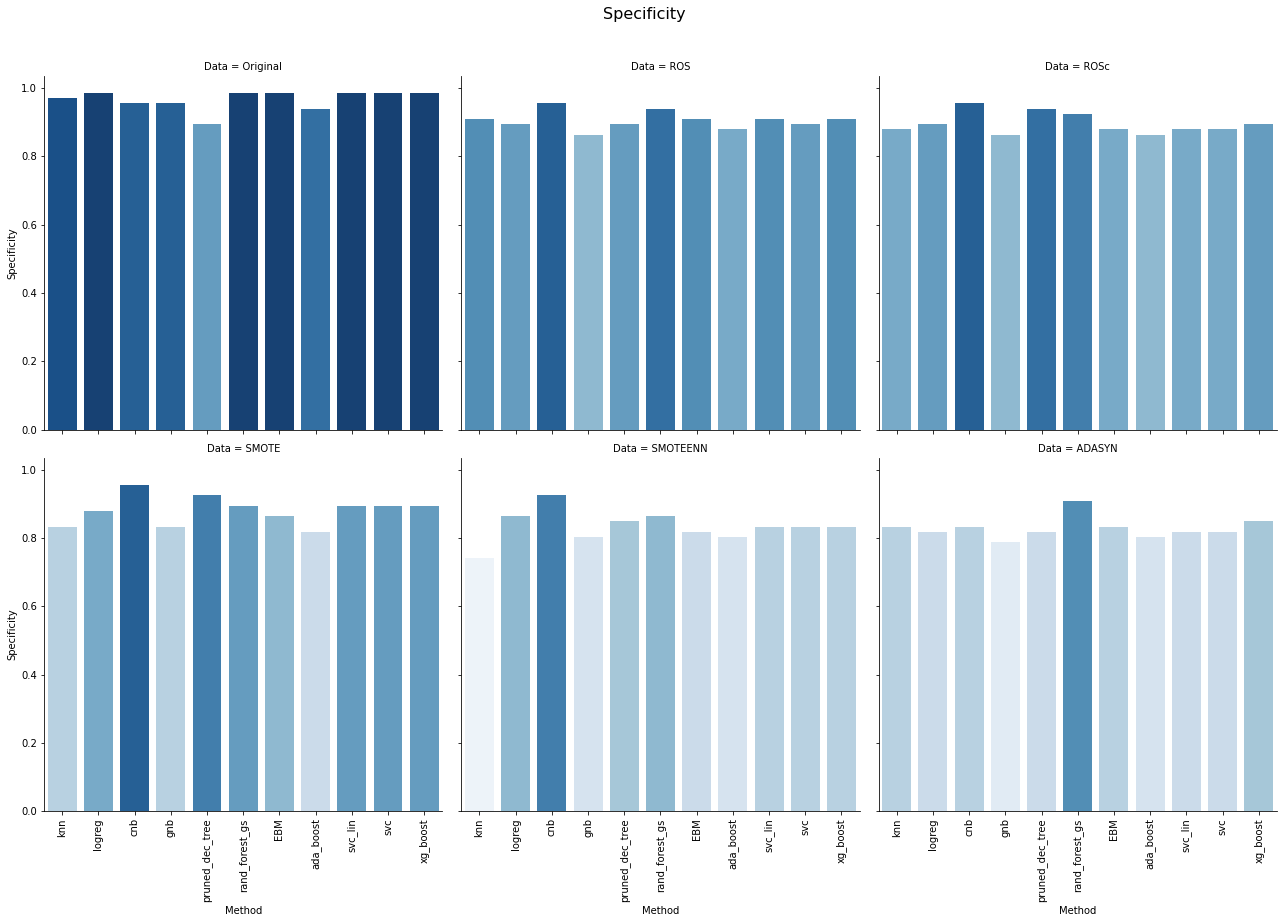

In [ ]:
g = sns.catplot(data = results_whole,
            x = 'Method',
            y = 'Specificity',
            col = 'Data',
            kind = 'bar',
            hue = 'Specificity',
            legend = False,
            palette = 'Blues',
            dodge = False,
            height = 6,
            col_wrap = 3)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Specificity', fontsize=16)
g.set_xticklabels(rotation=90)

In [ ]:
feature_imp_whole['Feature_names'].unique()

array(['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age',
       'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp',
       'waist', 'hip', 'waist_hip_ratio', 'glucose x systolic_bp',
       'glucose x waist', 'glucose x chol_hdl_ratio',
       'glucose x hdl_chol', 'cholesterol x glucose', 'glucose x bmi',
       'glucose x age', 'glucose x waist_hip_ratio', 'glucose x weight',
       'glucose x diastolic_bp', 'hdl_chol x age', 'glucose x hip',
       'cholesterol x systolic_bp', 'cholesterol x chol_hdl_ratio',
       'chol_hdl_ratio x age', 'glucose x height',
       'chol_hdl_ratio x weight', 'systolic_bp x hip',
       'chol_hdl_ratio x waist', 'chol_hdl_ratio x hip'], dtype=object)

In [ ]:
results_whole.columns

Index(['Method', 'Train F1 score', 'Test F1 score', 'Sensitivity',
       'Specificity', 'Data'],
      dtype='object')

In [ ]:
results_whole.to_csv('results_whole.csv')
feature_imp_whole.to_csv('feature_imp_whole.csv')

### Exact values
Below we present the tables with exact values of the scores for the original data as well as for each of the data balancing techniques.

**Original data**

In [ ]:
results_whole[results_whole["Data"] == 'Original']

Method  Train F1 score  ...  Specificity      Data
0               knn        0.838710  ...     0.969697  Original
1            logreg        0.744186  ...     0.984848  Original
2               cnb        0.694737  ...     0.954545  Original
3               gnb        0.716981  ...     0.954545  Original
4   pruned_dec_tree        0.819048  ...     0.893939  Original
5    rand_forest_gs        1.000000  ...     0.984848  Original
6               EBM        0.873563  ...     0.984848  Original
7         ada_boost        0.989474  ...     0.939394  Original
8           svc_lin        0.722892  ...     0.984848  Original
9               svc        0.744186  ...     0.984848  Original
10         xg_boost        0.744186  ...     0.984848  Original

[11 rows x 6 columns]

**Naive random oversampling**

In [ ]:
results_whole[results_whole["Data"] == 'ROS']

Method  Train F1 score  ...  Specificity  Data
0               knn        1.000000  ...     0.909091   ROS
1            logreg        0.888889  ...     0.893939   ROS
2               cnb        0.806867  ...     0.954545   ROS
3               gnb        0.859885  ...     0.863636   ROS
4   pruned_dec_tree        0.994350  ...     0.893939   ROS
5    rand_forest_gs        1.000000  ...     0.939394   ROS
6               EBM        1.000000  ...     0.909091   ROS
7         ada_boost        0.988722  ...     0.878788   ROS
8           svc_lin        0.892368  ...     0.909091   ROS
9               svc        0.919540  ...     0.893939   ROS
10         xg_boost        1.000000  ...     0.909091   ROS

[11 rows x 6 columns]

**Naive random oversampling with shrinkage**

In [ ]:
results_whole[results_whole["Data"] == 'ROSc']

Method  Train F1 score  ...  Specificity  Data
0               knn        1.000000  ...     0.878788  ROSc
1            logreg        0.882353  ...     0.893939  ROSc
2               cnb        0.808602  ...     0.954545  ROSc
3               gnb        0.870722  ...     0.863636  ROSc
4   pruned_dec_tree        1.000000  ...     0.939394  ROSc
5    rand_forest_gs        1.000000  ...     0.924242  ROSc
6               EBM        1.000000  ...     0.878788  ROSc
7         ada_boost        0.986817  ...     0.863636  ROSc
8           svc_lin        0.886275  ...     0.878788  ROSc
9               svc        0.919231  ...     0.878788  ROSc
10         xg_boost        1.000000  ...     0.893939  ROSc

[11 rows x 6 columns]

**SMOTE**

In [ ]:
results_whole[results_whole["Data"] == 'SMOTE']

Method  Train F1 score  ...  Specificity   Data
0               knn        1.000000  ...     0.833333  SMOTE
1            logreg        0.856582  ...     0.878788  SMOTE
2               cnb        0.767184  ...     0.954545  SMOTE
3               gnb        0.842105  ...     0.833333  SMOTE
4   pruned_dec_tree        1.000000  ...     0.924242  SMOTE
5    rand_forest_gs        1.000000  ...     0.893939  SMOTE
6               EBM        0.996226  ...     0.863636  SMOTE
7         ada_boost        0.968105  ...     0.818182  SMOTE
8           svc_lin        0.852071  ...     0.893939  SMOTE
9               svc        0.907692  ...     0.893939  SMOTE
10         xg_boost        1.000000  ...     0.893939  SMOTE

[11 rows x 6 columns]

**SMOTEENN**

In [ ]:
results_whole[results_whole["Data"] == 'SMOTEENN']

Method  Train F1 score  ...  Specificity      Data
0               knn        1.000000  ...     0.742424  SMOTEENN
1            logreg        0.909836  ...     0.863636  SMOTEENN
2               cnb        0.813953  ...     0.924242  SMOTEENN
3               gnb        0.889344  ...     0.803030  SMOTEENN
4   pruned_dec_tree        1.000000  ...     0.848485  SMOTEENN
5    rand_forest_gs        1.000000  ...     0.863636  SMOTEENN
6               EBM        1.000000  ...     0.818182  SMOTEENN
7         ada_boost        1.000000  ...     0.803030  SMOTEENN
8           svc_lin        0.935743  ...     0.833333  SMOTEENN
9               svc        0.961460  ...     0.833333  SMOTEENN
10         xg_boost        1.000000  ...     0.833333  SMOTEENN

[11 rows x 6 columns]

**ADASYN**

In [ ]:
results_whole[results_whole["Data"] == 'ADASYN']

Method  Train F1 score  ...  Specificity    Data
0               knn        1.000000  ...     0.833333  ADASYN
1            logreg        0.848369  ...     0.818182  ADASYN
2               cnb        0.706667  ...     0.833333  ADASYN
3               gnb        0.795276  ...     0.787879  ADASYN
4   pruned_dec_tree        0.980695  ...     0.818182  ADASYN
5    rand_forest_gs        1.000000  ...     0.909091  ADASYN
6               EBM        1.000000  ...     0.833333  ADASYN
7         ada_boost        0.963947  ...     0.803030  ADASYN
8           svc_lin        0.834615  ...     0.818182  ADASYN
9               svc        0.882353  ...     0.818182  ADASYN
10         xg_boost        1.000000  ...     0.848485  ADASYN

[11 rows x 6 columns]

## Conclusions

During our experiment with the diabetes data, we explored various ML methods. 

Our data set was rather small (even with generated additional samples) but we could clearly see differences in computation time. The heaviest in that sense was:
* random forest
* XG boost

We did there the most extensive search of optimal parameters. 

One of the shortes in terms of execution time method was logistic regression and it appeared to be as good as the methods mentioned above.

We could see changes in sensitivity and specificity with experimenting with different data balancing techniques. The F1 score remained mostly the same as for original data (got slightly worse for two data generating methods though). The greatest difference was visible in sensitivity scores. For original data the sensitivity was rather poor (around 60-75%). The data generation resulted in great improvement in all of the methods! We could obain scores as high as 100% (almost)! Every method decreased slightly specificity but given the improvements in sensitivity and keeping the same level of F1 we can see that generating the new samples was indeed benefitial.

It comes as no surprise that the most important feature, as selscted by each od the feature importance techniques was 'glucose'. The other imporatnt variables were among others 'age' and 'cholesterol'.